<a href="https://colab.research.google.com/github/raphael-fawaz/Financial-Markets-Analysis-and-Prediction/blob/Bi-LSTM-(Dow-Jones-%26-Nasdaq)---Close-Price/Bi_LSTM_(Dow_Jones_%26_Nasdaq)_Close_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bi-LSTM (Dow Jones & Nasdaq) - Close Price

In [1]:
# pip install yfinance

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot

### Getting the data

In [4]:
dow_ticker = "^DJI"
nasdaq_ticker = "^IXIC"
start_date = "2010-01-01"
end_date = "2024-5-31"
dow_data = yf.download(dow_ticker, start=start_date, end=end_date)
dow_data.to_csv("dow_data.csv")
nasdaq_data = yf.download(nasdaq_ticker, start=start_date, end=end_date)
nasdaq_data.to_csv("nasdaq_data.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Dow Jones

In [5]:
dow_data = pd.read_csv("dow_data.csv", index_col="Date", parse_dates=True)
dow_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10604.969727,10430.690430,10583.959961,10583.959961,179780000
2010-01-05,10584.559570,10584.559570,10522.519531,10572.019531,10572.019531,188540000
2010-01-06,10564.719727,10594.990234,10546.549805,10573.679688,10573.679688,186040000
2010-01-07,10571.110352,10612.370117,10505.209961,10606.860352,10606.860352,217390000
2010-01-08,10606.400391,10619.400391,10554.330078,10618.190430,10618.190430,172710000


In [6]:
dow_close = dow_data['Close'].values.reshape(-1, 1)

### Normalizing the data

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
dow_close_scaled = sc.fit_transform(dow_close)

### Create the sequence

In [8]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

In [9]:
seq_length = 60  # Use 60 days of data to predict the next day's price
dow_sequences, dow_labels = create_sequences(dow_close_scaled, seq_length)

### splitting the data

In [10]:
# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences = dow_sequences[:-test_size]
test_sequences = dow_sequences[-test_size:]
train_labels = dow_labels[:-test_size]
test_labels = dow_labels[-test_size:]

## LSTM

### Train the lstm model

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional

In [12]:
regressor = Sequential()

regressor.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (train_sequences.shape[1], 1))))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
regressor.add(Dropout(0.2))

regressor.add(Bidirectional(LSTM(units = 50)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(train_sequences, train_labels, epochs = 100, batch_size = 32)

Epoch 1/100
110/110 [==============================] - 17s 25ms/step - loss: 0.0113
Epoch 2/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0018
Epoch 3/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0018
Epoch 4/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0016
Epoch 5/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0014
Epoch 6/100
110/110 [==============================] - 3s 24ms/step - loss: 0.0013
Epoch 7/100
110/110 [==============================] - 2s 21ms/step - loss: 0.0013
Epoch 8/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0014
Epoch 9/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0013
Epoch 10/100
110/110 [==============================] - 3s 28ms/step - loss: 0.0011
Epoch 11/100
110/110 [==============================] - 3s 23ms/step - loss: 0.0012
Epoch 12/100
110/110 [==============================] - 3s 25ms/step - loss: 0.0012


### Predict on the test set

In [13]:
predicted_stock_price = regressor.predict(test_sequences)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#real_price = sc.inverse_transform(dow_test)

2/2 [==============================] - 2s 13ms/step


### RMSE Evaluation

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_labels, predicted_stock_price))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.012570174504024137


### Plotting

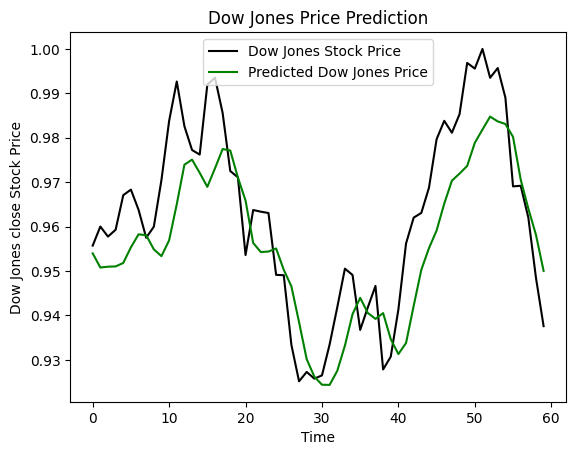

In [15]:
plt.plot(test_labels, color = 'black', label = 'Dow Jones Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Dow Jones Price')
plt.title('Dow Jones Price Prediction')
plt.xlabel('Time')
plt.ylabel('Dow Jones close Stock Price')
plt.legend()
plt.show()

### Project the data on the future next 30 days

1/1 [==============================] - 0s 24ms/step
Predicted Dow Jones Prices for the Next 30 Days:
2024-05-31: 38217.68
2024-06-01: 38103.88
2024-06-02: 38029.73
2024-06-03: 37976.69
2024-06-04: 37933.18
2024-06-05: 37893.66
2024-06-06: 37856.80
2024-06-07: 37823.18
2024-06-08: 37793.73
2024-06-09: 37767.88
2024-06-10: 37744.07
2024-06-11: 37720.50
2024-06-12: 37696.58
2024-06-13: 37675.01
2024-06-14: 37656.98
2024-06-15: 37642.97
2024-06-16: 37630.57
2024-06-17: 37620.40
2024-06-18: 37613.48
2024-06-19: 37610.68
2024-06-20: 37610.88
2024-06-21: 37615.88
2024-06-22: 37621.22
2024-06-23: 37625.77
2024-06-24: 37627.86
2024-06-25: 37628.46
2024-06-26: 37626.11
2024-06-27: 37624.15
2024-06-28: 37623.82
2024-06-29: 37625.48


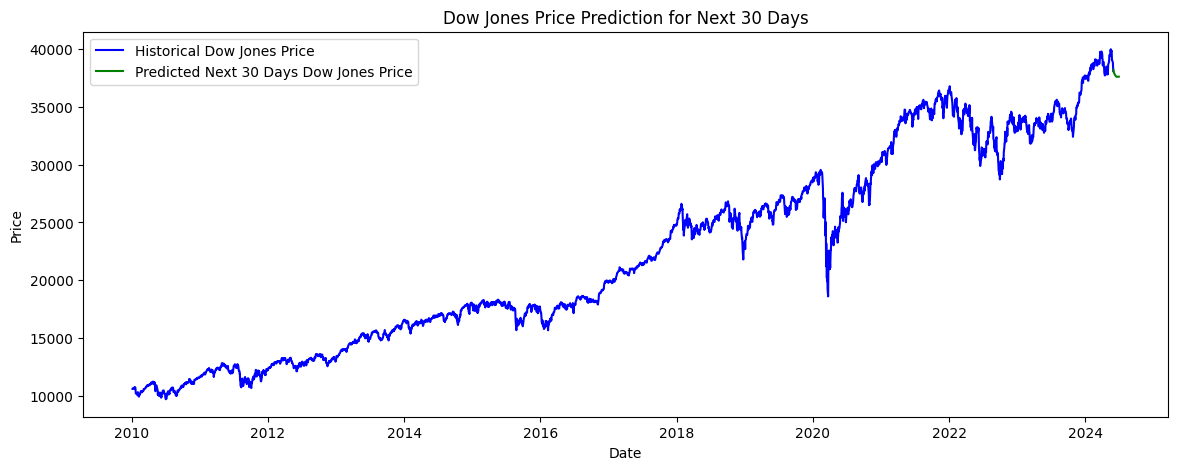

In [17]:
# Predict the next 30 days
last_sequence = dow_close_scaled[-seq_length:]  # Last 60 days
next_30_days = []

for _ in range(30):
    next_day_pred = regressor.predict(last_sequence.reshape(1, seq_length, 1))
    next_30_days.append(next_day_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_day_pred)

# Inverse transform the predictions
next_30_days = sc.inverse_transform(np.array(next_30_days).reshape(-1, 1))

last_date = dow_data.index[-1]
next_dates = pd.date_range(start=last_date, periods=30) + pd.DateOffset(days=1)
print("Predicted Dow Jones Prices for the Next 30 Days:")
for date, price in zip(next_dates, next_30_days):
    print(f"{date.date()}: {price[0]:.2f}")

plt.figure(figsize=(14, 5))
plt.plot(dow_data.index, dow_close, color='blue', label='Historical Dow Jones Price')
plt.plot(next_dates, next_30_days, color='green', label='Predicted Next 30 Days Dow Jones Price')
plt.title('Dow Jones Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## NASDAQ

In [30]:
nasdaq_data = pd.read_csv("nasdaq_data.csv", index_col="Date", parse_dates=True)
nasdaq_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000


In [31]:
nasdaq_close = nasdaq_data['Close'].values.reshape(-1, 1)
sc = MinMaxScaler(feature_range = (0,1))
nasdaq_close_scaled = sc.fit_transform(nasdaq_close)
nasdaq_sequences, nasdaq_labels = create_sequences(nasdaq_close_scaled, seq_length)

In [32]:
# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences_nasdaq = nasdaq_sequences[:-test_size]
test_sequences_nasdaq = nasdaq_sequences[-test_size:]
train_labels_nasdaq = nasdaq_labels[:-test_size]
test_labels_nasdaq = nasdaq_labels[-test_size:]

In [33]:
regressor_nasdaq = Sequential()

regressor_nasdaq.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (train_sequences_nasdaq.shape[1], 1))))
regressor_nasdaq.add(Dropout(0.2))

regressor_nasdaq.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
regressor_nasdaq.add(Dropout(0.2))

regressor_nasdaq.add(Bidirectional(LSTM(units = 50)))
regressor_nasdaq.add(Dropout(0.2))

regressor_nasdaq.add(Dense(units = 1))

regressor_nasdaq.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor_nasdaq.fit(train_sequences_nasdaq, train_labels_nasdaq, epochs = 100, batch_size = 32)

Epoch 1/100
110/110 [==============================] - 13s 20ms/step - loss: 0.0051
Epoch 2/100
110/110 [==============================] - 2s 20ms/step - loss: 0.0018
Epoch 3/100
110/110 [==============================] - 2s 20ms/step - loss: 0.0013
Epoch 4/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0012
Epoch 5/100
110/110 [==============================] - 3s 27ms/step - loss: 0.0014
Epoch 6/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0011
Epoch 7/100
110/110 [==============================] - 2s 19ms/step - loss: 0.0014
Epoch 8/100
110/110 [==============================] - 2s 20ms/step - loss: 9.4579e-04
Epoch 9/100
110/110 [==============================] - 2s 20ms/step - loss: 8.9642e-04
Epoch 10/100
110/110 [==============================] - 2s 22ms/step - loss: 9.5057e-04
Epoch 11/100
110/110 [==============================] - 3s 26ms/step - loss: 9.9922e-04
Epoch 12/100
110/110 [==============================] - 2s 20ms/step

In [34]:
predicted_stock_price_nasdaq = regressor_nasdaq.predict(test_sequences_nasdaq)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#real_price = sc.inverse_transform(test_labels_nasdaq)

2/2 [==============================] - 2s 12ms/step


In [35]:
rmse = np.sqrt(mean_squared_error(test_labels_nasdaq, predicted_stock_price_nasdaq))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.021339303120663032


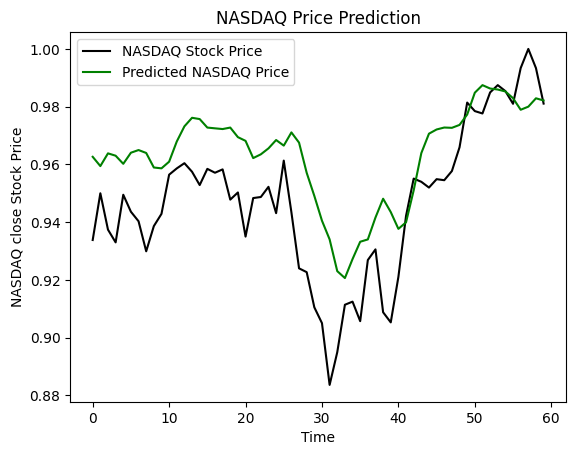

In [36]:
plt.plot(test_labels_nasdaq, color = 'black', label = 'NASDAQ Stock Price')
plt.plot(predicted_stock_price_nasdaq, color = 'green', label = 'Predicted NASDAQ Price')
plt.title('NASDAQ Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ close Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 22ms/step
Predicted NASDAQ Prices for the Next 30 Days:
2024-05-31: 16676.29
2024-06-01: 16607.33
2024-06-02: 16557.22
2024-06-03: 16537.62
2024-06-04: 16548.41
2024-06-05: 16582.75
2024-06-06: 16636.27
2024-06-07: 16702.37
2024-06-08: 16776.04
2024-06-09: 16850.16
2024-06-10: 16920.08
2024-06-11: 16981.00
2024-06-12: 17031.08
2024-06-13: 17069.53
2024-06-14: 17097.51
2024-06-15: 17116.90
2024-06-16: 17128.53
2024-06-17: 17133.46
2024-06-18: 17131.68
2024-06-19: 17123.63
2024-06-20: 17108.13
2024-06-21: 17085.72
2024-06-22: 17053.94
2024-06-23: 17011.66
2024-06-24: 16957.56
2024-06-25: 16891.24
2024-06-26: 16809.42
2024-06-27: 16714.90
2024-06-28: 16613.62
2024-06-29: 16511.47


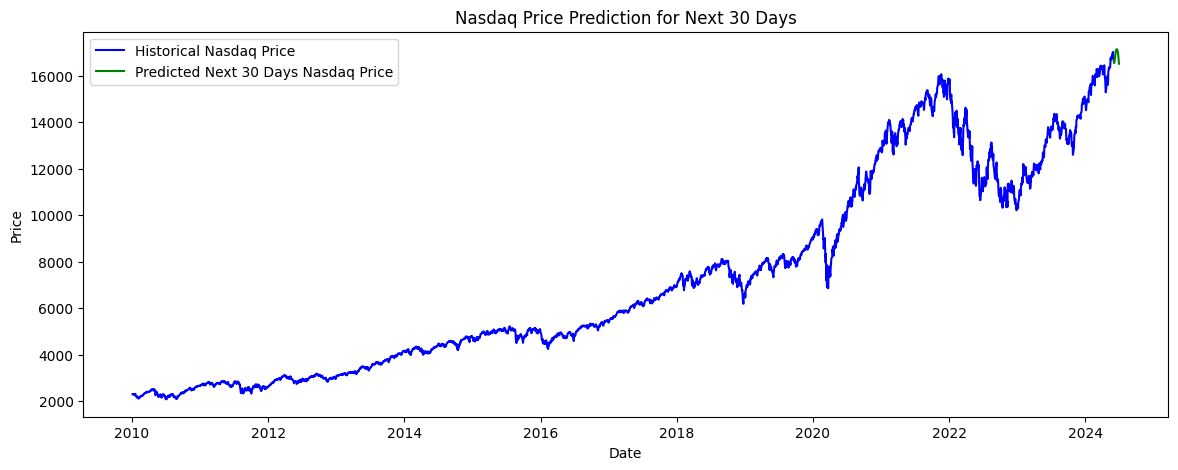

In [37]:
# Predict the next 30 days
last_sequence = nasdaq_close_scaled[-seq_length:]  # Last 60 days
next_30_days = []

for _ in range(30):
    next_day_pred = regressor_nasdaq.predict(last_sequence.reshape(1, seq_length, 1))
    next_30_days.append(next_day_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_day_pred)

# Inverse transform the predictions
next_30_days = sc.inverse_transform(np.array(next_30_days).reshape(-1, 1))

last_date = nasdaq_data.index[-1]
next_dates = pd.date_range(start=last_date, periods=30) + pd.DateOffset(days=1)

print("Predicted NASDAQ Prices for the Next 30 Days:")
for date, price in zip(next_dates, next_30_days):
    print(f"{date.date()}: {price[0]:.2f}")

plt.figure(figsize=(14, 5))
plt.plot(nasdaq_data.index, nasdaq_close, color='blue', label='Historical Nasdaq Price')
plt.plot(next_dates, next_30_days, color='green', label='Predicted Next 30 Days Nasdaq Price')
plt.title('Nasdaq Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()